Multi layer perceptron

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
#!pip install torchvision

In [ ]:
import torch
print(torch.cuda.is_available())

False


In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
# Training set length
dataset_size = len(dataset)
dataset_size

50000

In [ ]:
#Test set length
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [ ]:
# output classes
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
num_classes = len(dataset.classes)
num_classes

10

In [ ]:
# Image Shape
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 9
Label (textual): truck


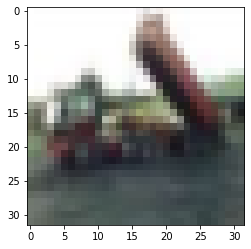

In [ ]:
img, label = dataset[2]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
# Number of images in each class
x = []
for i in range(dataset_size):
    x.append(dataset[i][1])
uimg = torch.tensor(x).unique(sorted=True)
uimg_count = torch.stack([(torch.tensor(x)==i).sum() for i in uimg])
for i in range(len(uimg)):
    print(f'{classes[i]}: {uimg_count[i].item()} count')

airplane: 5000 count
automobile: 5000 count
bird: 5000 count
cat: 5000 count
deer: 5000 count
dog: 5000 count
frog: 5000 count
horse: 5000 count
ship: 5000 count
truck: 5000 count


**Preparing the data for training **

In [ ]:
# Dividing training set into train(90%) and validation(10%)

In [ ]:
torch.manual_seed(43) # PyTorch's random number generator to a seed value of 43
val_size = 5000
train_size = len(dataset) - val_size

In [ ]:
#random_split method to create the training & validation sets
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

Creating data loaders to load data in batches

In [ ]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Base Model class

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*32*32
output_size = 10

In [ ]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1536)
        self.fc2 = nn.Linear(1536, 768)
        self.fc3 = nn.Linear(768, 384)
        self.fc4 = nn.Linear(384, 128)
        self.fc5 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out

In [ ]:
model = to_device(CIFAR10Model(), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.10271139442920685, 'val_loss': 2.3030784130096436}]

In [ ]:
history += fit(15, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.0297, val_acc: 0.2378
Epoch [1], val_loss: 1.8763, val_acc: 0.3095
Epoch [2], val_loss: 1.7431, val_acc: 0.3749
Epoch [3], val_loss: 1.7234, val_acc: 0.3848
Epoch [4], val_loss: 1.8067, val_acc: 0.3514
Epoch [5], val_loss: 1.8093, val_acc: 0.3401
Epoch [6], val_loss: 1.5680, val_acc: 0.4318
Epoch [7], val_loss: 1.6045, val_acc: 0.4198
Epoch [8], val_loss: 1.7027, val_acc: 0.4050
Epoch [9], val_loss: 1.5316, val_acc: 0.4490
Epoch [10], val_loss: 1.5385, val_acc: 0.4361
Epoch [11], val_loss: 1.5395, val_acc: 0.4369
Epoch [12], val_loss: 1.5469, val_acc: 0.4561
Epoch [13], val_loss: 1.6323, val_acc: 0.4204
Epoch [14], val_loss: 1.4921, val_acc: 0.4714


In [ ]:
history += fit(5, 0.0001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.4153, val_acc: 0.4989
Epoch [1], val_loss: 1.3897, val_acc: 0.5108
Epoch [2], val_loss: 1.3789, val_acc: 0.5160
Epoch [3], val_loss: 1.3734, val_acc: 0.5185
Epoch [4], val_loss: 1.3700, val_acc: 0.5193


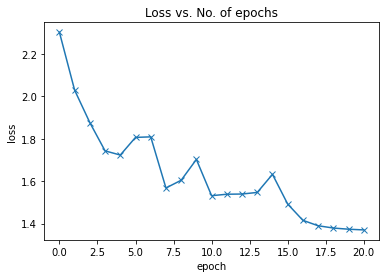

In [ ]:
plot_losses(history)

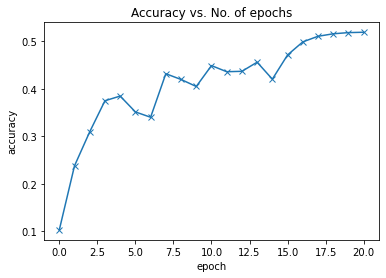

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.530957043170929, 'val_loss': 1.3207964897155762}